# NRS - Project Work - Group 1

### Table of Contents
- [Importing Libraries and Data](#Lib_Data)
- [Merging Datasets](#merging)
- [Data preparation & Exploration](#Preparation_Exploration)
- [The Model](#Model)

<a id="Lib_Data"></a>
### Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# regular expressione and tools for sentiment analysis
from textblob import TextBlob
import re 

from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, classification_report # plot confusion matrix
from sklearn.model_selection import train_test_split #split train & test
from sklearn.model_selection import GridSearchCV #gridsearch

from sklearn import feature_selection
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
missing_values = [''] #define values to be identified as NaN in the datasets

df_crm = pd.read_csv('crm_model.csv', keep_default_na=False, na_values=missing_values, decimal=',') #import CRM_model
df_finance = pd.read_csv('finance_model.csv', keep_default_na=False, na_values=missing_values, decimal=',') #import finance_model
df_sales = pd.read_csv('sales_model.csv', keep_default_na=False, na_values=missing_values, decimal=',') #import sales_model
df_twitter = pd.read_csv('twitter_model.csv', keep_default_na=False, na_values=missing_values, decimal=',') #import twitter_azure

<a id="Joining_Datasets"></a>

<a id="merging"></a>
### Merging Datasets

In [3]:
# column id renaming to join the datasets
df_crm = df_crm.rename(columns={'ID_CRM': 'id'}) 
df_finance = df_finance.rename(columns={'ID_FINANCE': 'id'})
df_sales = df_sales.rename(columns={'ID_SALES': 'id'})
df_twitter = df_twitter.rename(columns={'ID_SALES': 'id'})

By observing the structure of each id we find a pattern to extract a common unique id:

<img src="img/ID_schema.png"></img>

In [4]:
# df_crm unique_id extraction
df_crm.id = np.where(df_crm.Income_Level.str.len() == 2,\
                     df_crm.id.str.slice(start = 1, stop = -2),\
                     df_crm.id.str.slice(start = 1, stop = -1))

# df_finance unique_id extraction
df_finance.id = np.where(df_finance.Special_Pay.str.len() == 2,\
                         df_finance.id.str.slice(start = 2),\
                         df_finance.id.str.slice(start = 0))

# df_sales unique_id extraction
df_sales.id = np.where(df_sales.Program_Code.str.len() == 2,\
                       df_sales.id.str.slice(start = 2, stop = -1),\
                       df_sales.id.str.slice(start = 3, stop = -1))

# df_twitter unique_id extraction
df_twitter.id = df_twitter.id.str.extract(r'(\d+)', expand=False)

#### Sentiment Analysis

In [5]:
# Create a function to clean the tweets
def cleanTxt(text):
    text = text.lower()
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
    text = re.sub('&amp;', '', text) #remove ampersand
    text = re.sub('\n',' ', text) #remove breakline
    text = re.sub("[^\w]", " ",  text) #remove all distinct to word
    text = re.sub('å', '', text)
    text = re.sub('ä', '', text)
    text = re.sub('ā', '', text)


    text = re.sub(' +', ' ', text) #remove multiple spaces

    # clean emoticons
    return text

In [6]:
# Clean the tweets
df_twitter['text'] = df_twitter['text'].apply(cleanTxt)

In [7]:
#get the sentiment of each tweet first, then calculate the mean

df_twitter_merged = df_twitter.copy()
df_twitter_merged['polarity'] = df_twitter_merged['text'].apply(lambda x: TextBlob(x).sentiment[0])
df_twitter_merged['subjectivity'] = df_twitter_merged['text'].apply(lambda x: TextBlob(x).sentiment[1])

df_twitter_merged = df_twitter_merged.groupby('id').mean()

In [8]:
# create a single table to join the datasets
df_merged = df_sales.merge(df_crm, on="id", how="inner").merge(df_finance, on="id", how="inner").merge(df_twitter_merged, on="id", how="left")
df_merged.shape

(4148, 56)

<a id="Preparation_Exploration"></a>
### Data preparation & Exploration

In [9]:
df = df_merged.copy()
df.head()

,id,Program_Code,From_Grade,To_Grade,Group_State,Days,Travel_Type,Departure_Date,Return_Date,Early_RPL,...,FRP_Active,FRP_Cancelled,FRP_Take_up_percent_,EZ_Pay_Take_Up_Rate,School_Sponsor,SPR_Group_Revenue,FPP_to_PAX,Num_of_Non_FPP_PAX,polarity,subjectivity
0,1387,CC,10.0,10.0,CA,24,A,04/07/2019,05/01/2019,05/11/2018,...,9,1,0.345746,0.103222,0,2167,0.991415,1,0.833333,0.958333
1,139,CC,5.0,6.0,CA,18,A,04/30/2019,05/18/2019,03/05/2018,...,12,3,0.570244,0.119431,0,2708,0.888166,3,0.000000,0.000000
2,1701,CC,8.0,8.0,CA,24,A,05/08/2019,06/01/2019,02/07/2018,...,9,3,0.404058,0.104028,0,2148,0.915161,3,1.000000,0.533333
3,1773,CC,7.0,7.0,OR,13,A,03/17/2019,03/30/2019,NaN,...,3,0,0.517738,0.000000,1,1989,0.866585,1,1.000000,1.000000
4,1830,CC,7.0,8.0,CA,30,A,06/23/2019,07/23/2019,02/25/2018,...,44,9,0.721320,0.381479,1,2388,0.887128,7,0.000000,0.000000


#### Find out how imbalanced is the dataset:

1    0.607281
0    0.392719
Name: Retained, dtype: float64

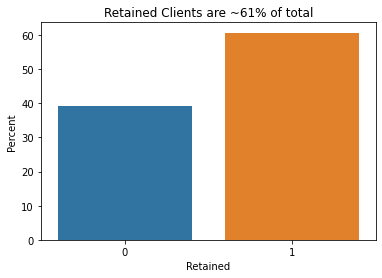

In [10]:
ax = sns.barplot(x="Retained", y="Retained", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set_title('Retained Clients are ~61% of total')
ax.set(ylabel="Percent")
df['Retained'].value_counts(normalize=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4148 entries, 0 to 4147
Data columns (total 56 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              4148 non-null   object 
 1   Program_Code                    4148 non-null   object 
 2   From_Grade                      3922 non-null   float64
 3   To_Grade                        3879 non-null   float64
 4   Group_State                     4148 non-null   object 
 5   Days                            4148 non-null   int64  
 6   Travel_Type                     4148 non-null   object 
 7   Departure_Date                  4148 non-null   object 
 8   Return_Date                     4148 non-null   object 
 9   Early_RPL                       2981 non-null   object 
 10  Latest_RPL                      4112 non-null   object 
 11  Cancelled_Pax                   4148 non-null   int64  
 12  Total_Discount_Pax              41

In [12]:
def dummification(df):
    #_______________ Categorical Dummification
    categorical = df.select_dtypes(exclude=np.number).columns.tolist()
    df = pd.get_dummies(df, columns = categorical, prefix = categorical)
    
    return df

In [13]:
def cleaning_1(df):
    #______________ id
    df.drop(columns=['id'], inplace=True)


    #______________ Program_Code
    #wrong values replaced with na
    df['Program_Code'] = df['Program_Code'].replace({'FN': np.nan})
    #missing values replaced with mode of the parent group
    df['Program_Code'] = df.groupby(['MajorProgramCode'], sort=False)['Program_Code'].apply(lambda x: x.fillna(x.mode().iloc[0]))
    #df.drop(columns=['Program_Code'], inplace=True)

    #______________ From_Grade
    #missing values replaced with the median
    df['From_Grade'] = df['From_Grade'].fillna(df['From_Grade'].median())


    #______________ To_Grade
    #missing values replaced with the median (with respect to the subgroup)
    df['To_Grade'] = df.groupby(['From_Grade'], sort=False)['To_Grade'].apply(lambda x: x.fillna(x.median()))
    df['To_Grade'] = df['To_Grade'].fillna(df['To_Grade'].median())


    #____**NEW**____ Delta_From_To_Grade
    #Distance from lowest to highest grade in school of participants. When zero it represents an indicator for the trip
    #taken by a group comprising students from the same grade.
    df['Delta_From_To_Grade'] = df['To_Grade'] - df['From_Grade']


    #conversion to datetime
    df['Departure_Date'] = pd.to_datetime(df['Departure_Date'])


    #____**NEW**____ Departure_Date_DoY
    #conversion to day of the year
    df['Departure_Date_DoY'] = df['Departure_Date'].dt.dayofyear

    #_______________ Return_Date
    #conversion to datetime
    df['Return_Date'] = pd.to_datetime(df['Return_Date'])


    #____**NEW**____ Return_Date_DoY
    #conversion to day of the year
    df['Return_Date_DoY'] = df['Return_Date'].dt.dayofyear


    #_______________ Early_RPL
    #_______________ Latest_RPL
    #____**NEW**____ RPL_Value
    df['Early_RPL'] = pd.to_datetime(df['Early_RPL'])
    df['Latest_RPL'] = pd.to_datetime(df['Latest_RPL'])

    df['RPL_Value'] = np.where( (df['Early_RPL'].isna()) & (df['Latest_RPL'].isna()), 0, 1)

    df['Early_RPL'].fillna(df['Latest_RPL'].mode()[0], inplace=True)
    df['Latest_RPL'].fillna(df['Latest_RPL'].mode()[0], inplace=True)

    temp_min = df[['Early_RPL','Latest_RPL']].min(axis=1)
    temp_max = df[['Early_RPL','Latest_RPL']].max(axis=1)

    df['Early_RPL'] = temp_min
    df['Latest_RPL'] = temp_max


    #____**NEW**____ Early_RPL_DoY
    #____**NEW**____ Latest_RPL_DoY
    df['first_january'] = pd.to_datetime('1/1/' + str(df['Departure_Date'].dt.year[0]))
    df['Early_RPL_DoY'] = df['Early_RPL'] - df['first_january']
    df['Early_RPL_DoY'] = df['Early_RPL_DoY'].astype('timedelta64[D]').astype(int)
    df['Latest_RPL_DoY'] = df['Latest_RPL'] - df['first_january']
    df['Latest_RPL_DoY'] = df['Latest_RPL_DoY'].astype('timedelta64[D]').astype(int)


    #_______________ Initial_System_Date
    df['Initial_System_Date'] = pd.to_datetime(df['Initial_System_Date'])
    df['Initial_System_Date'].fillna(df['Initial_System_Date'].mode()[0], inplace=True)


    #____**NEW**____ Initial_System_Date_DoY
    df['Initial_System_Date_DoY'] = df['Initial_System_Date'] - df['first_january']
    df['Initial_System_Date_DoY'] = df['Initial_System_Date_DoY'].astype('timedelta64[D]').astype(int)

    
    #____**NEW**____ Delta_Initial_System_Date_Departure
    
    df['Delta_Initial_System_Date_Departure'] = df['Departure_Date_DoY'] - df['Initial_System_Date_DoY']
    

    #______________ DepartureMonth
    # pointless variable
    df.drop(columns=['DepartureMonth'], inplace=True)


    #_______________ GroupGradeTypeLow
    df['GroupGradeTypeLow'] = df['GroupGradeTypeLow'].fillna(df['GroupGradeTypeLow'].mode()[0])


    #_______________ GroupGradeTypeHigh
    df['GroupGradeTypeHigh'] = df.groupby(['GroupGradeTypeLow'], sort=False)['GroupGradeTypeHigh'].apply(lambda x: x.fillna(x.mode()[0]))
    df['GroupGradeTypeHigh'] = df['GroupGradeTypeHigh'].fillna(df['GroupGradeTypeHigh'].mode()[0])


    #_______________ GroupGradeType
    df['GroupGradeType'] = df['GroupGradeTypeLow'] + '->' + df['GroupGradeTypeHigh']


    #_______________ CRM_Segment
    df['CRM_Segment'].fillna(df['CRM_Segment'].mode()[0], inplace=True)


    #_______________ MDR_Low_Grade
    #_______________ MDR_High_Grade
    df['MDR_Low_Grade'].replace({'0': df['MDR_Low_Grade'].mode()[0]}, inplace=True)
    df['MDR_High_Grade'].replace({'NA': df['MDR_High_Grade'].mode()[0]}, inplace=True)


    #_______________ Total_School_Enrollment
    df['Total_School_Enrollment'] = df['Total_School_Enrollment'].replace({0: np.nan})
    df['Total_School_Enrollment'] = df['Total_School_Enrollment'].fillna(df['Total_School_Enrollment'].mean())


    #_______________ FPP_to_School_enrollment
    df['FPP_to_School_enrollment'] = df['FPP_to_School_enrollment'].fillna(df['FPP_to_School_enrollment'].mean())


    #____**NEW**____ FPP_to_School_enrollment_rev
    df['FPP_to_School_enrollment_rev'] = df['FPP'] / df['Total_School_Enrollment']


    #_______________ Poverty_Code
    df['Poverty_Code'] = df['Poverty_Code'].replace({'0': 'E'})


    #_______________ Income_Level
    df['Poverty_Code'] = df['Poverty_Code'].replace({'0': 'Z'})


    #_______________ FirstMeeting
    df['FirstMeeting'] = pd.to_datetime(df['FirstMeeting'])
    df['FirstMeeting'].fillna(df['FirstMeeting'].mode()[0], inplace=True)


    #____**NEW**____ FirstMeeting_DoY
    df['FirstMeeting_DoY'] = df['FirstMeeting'] - df['first_january']
    df['FirstMeeting_DoY'] = df['FirstMeeting_DoY'].astype('timedelta64[D]').astype(int)


    #_______________ LastMeeting
    df['LastMeeting'] = pd.to_datetime(df['LastMeeting'])
    df['LastMeeting'].fillna(df['LastMeeting'].mode()[0], inplace=True)


    #____**NEW**____ LastMeeting_DoY
    df['LastMeeting_DoY'] = df['LastMeeting'] - df['first_january']
    df['LastMeeting_DoY'] = df['LastMeeting_DoY'].astype('timedelta64[D]').astype(int)


    #_______________ DifferenceTraveltoFirstMeeting
    df['DifferenceTraveltoFirstMeeting'] = df['Departure_Date_DoY'] - df['FirstMeeting_DoY']


    #_______________ DifferenceTraveltoLastMeeting
    df['DifferenceTraveltoLastMeeting'] = df['Departure_Date_DoY'] - df['LastMeeting_DoY']


    #_______________ SchoolSizeIndicator
    df['SchoolSizeIndicator'].fillna(df['SchoolSizeIndicator'].mode()[0], inplace=True)


    #_______________ Deposit_Date
    df['Deposit_Date'] = pd.to_datetime(df['Deposit_Date'])


    #____**NEW**____ Deposit_Date_DoY
    df['Deposit_Date_DoY'] = df['Deposit_Date'] - df['first_january']
    df['Deposit_Date_DoY'] = df['Deposit_Date_DoY'].astype('timedelta64[D]').astype(int)


    #_______________ Special_Pay
    df['Special_Pay'] = df['Special_Pay'].replace({'0': df['Special_Pay'].mode()[0]})
    
    
    #_______________ Polarity
    df['polarity'].fillna(df['polarity'].mean(), inplace=True)
    
    
    #_______________ Subjectivity
    df['subjectivity'].fillna(df['subjectivity'].mean(), inplace=True)
    
    
    #____**NEW**____ Total_Pax_rev
    df['Total_Pax_rev'] = np.log(df['FPP'] + df['Total_Discount_Pax'])
    
    
    #____**NEW**____ SameGroupGradeType
    df['SameGroupGradeType'] = 0
    df.loc[df['GroupGradeTypeLow']==df['GroupGradeTypeHigh'],'SameGroupGradeType'] = 1
    

    #_______________ Drop Columns
    df.drop(columns=['first_january'], inplace=True)
    df.drop(columns=['Departure_Date', 'Return_Date', 'Early_RPL', 'Latest_RPL', 'FirstMeeting', 'LastMeeting', 'Initial_System_Date', 'Deposit_Date', 'FPP_to_School_enrollment', 'Total_Pax'], inplace=True)

In [14]:
cleaning_1(df)

In [15]:
#df.to_excel("final.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4148 entries, 0 to 4147
Data columns (total 58 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Program_Code                         4148 non-null   object 
 1   From_Grade                           4148 non-null   float64
 2   To_Grade                             4148 non-null   float64
 3   Group_State                          4148 non-null   object 
 4   Days                                 4148 non-null   int64  
 5   Travel_Type                          4148 non-null   object 
 6   Cancelled_Pax                        4148 non-null   int64  
 7   Total_Discount_Pax                   4148 non-null   int64  
 8   SPR_Product_Type                     4148 non-null   object 
 9   FPP                                  4148 non-null   int64  
 10  GroupGradeTypeLow                    4148 non-null   object 
 11  GroupGradeTypeHigh            

#### Data exploration

In [16]:
Numerical = df.select_dtypes(include=np.number).columns.tolist()

C:\Users\sportell\Anaconda3\envs\Data_Science\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\sportell\Anaconda3\envs\Data_Science\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


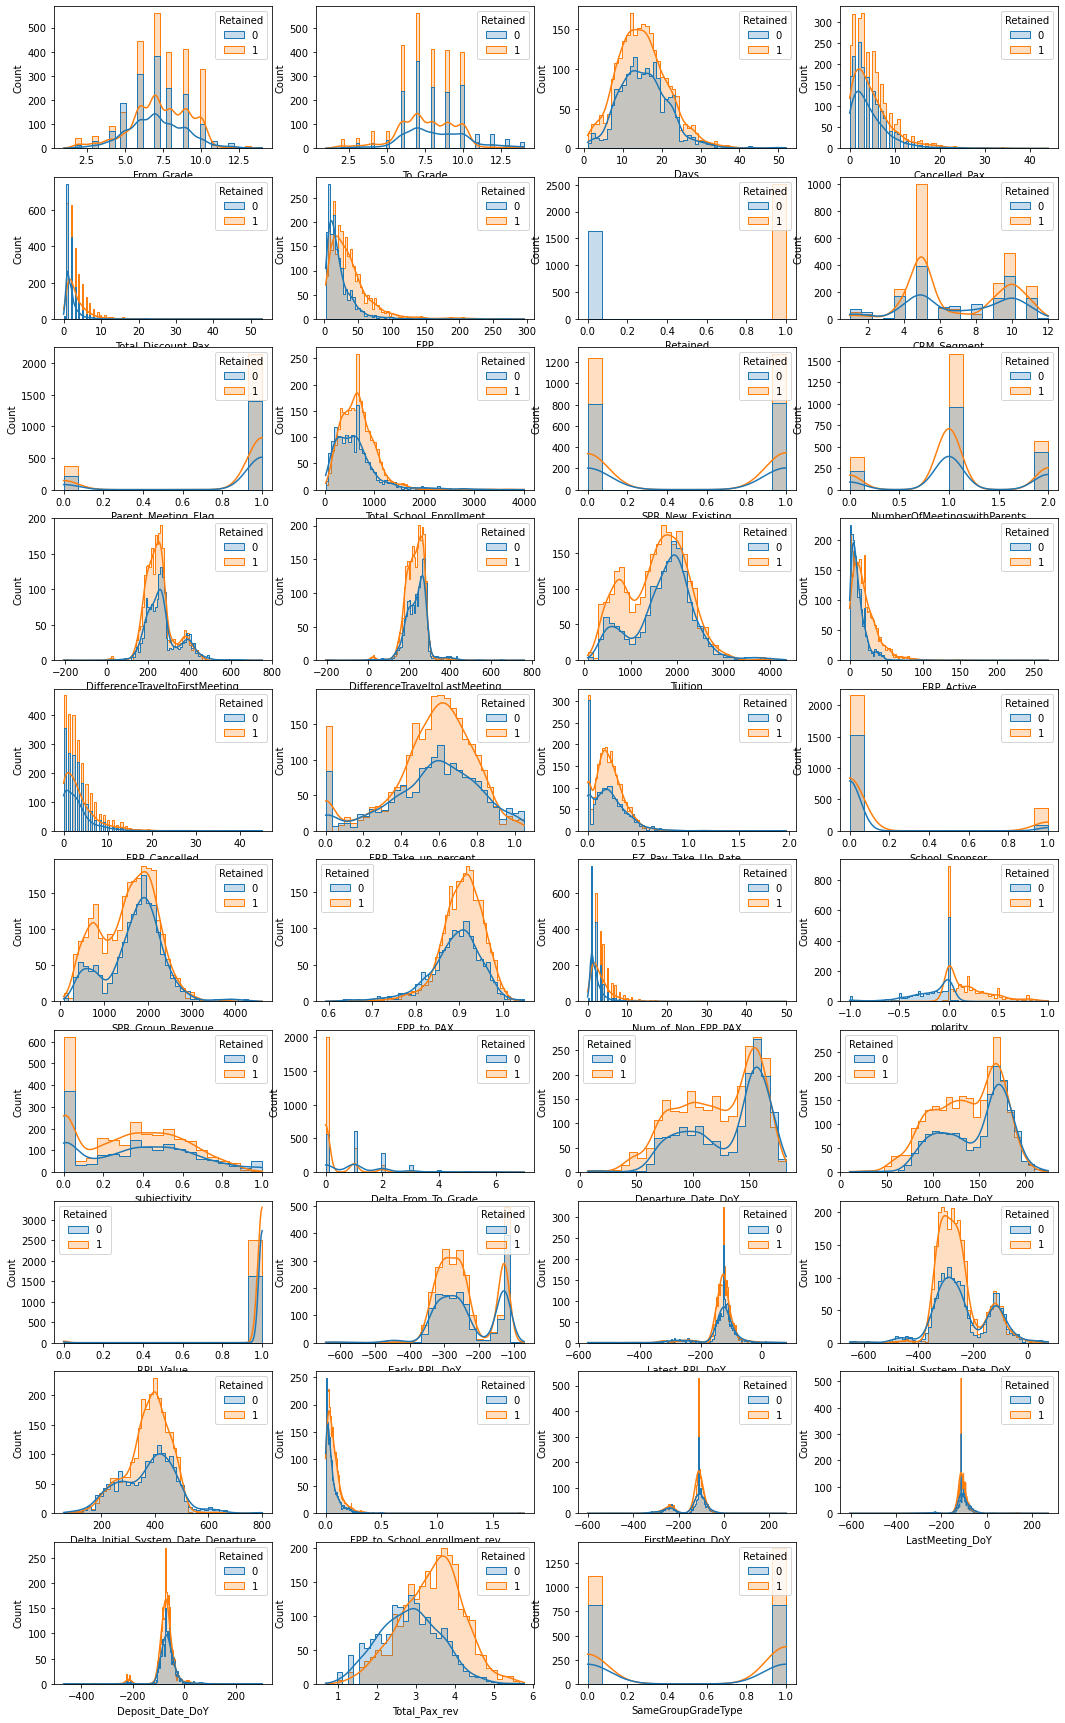

In [17]:
plt.figure(figsize=(18,34))

for i, feature in enumerate(Numerical):
    plt.subplot(11, 4, i+1)
    sns.histplot(data=df, x=feature, hue="Retained", element="step", kde=True)
plt.show()

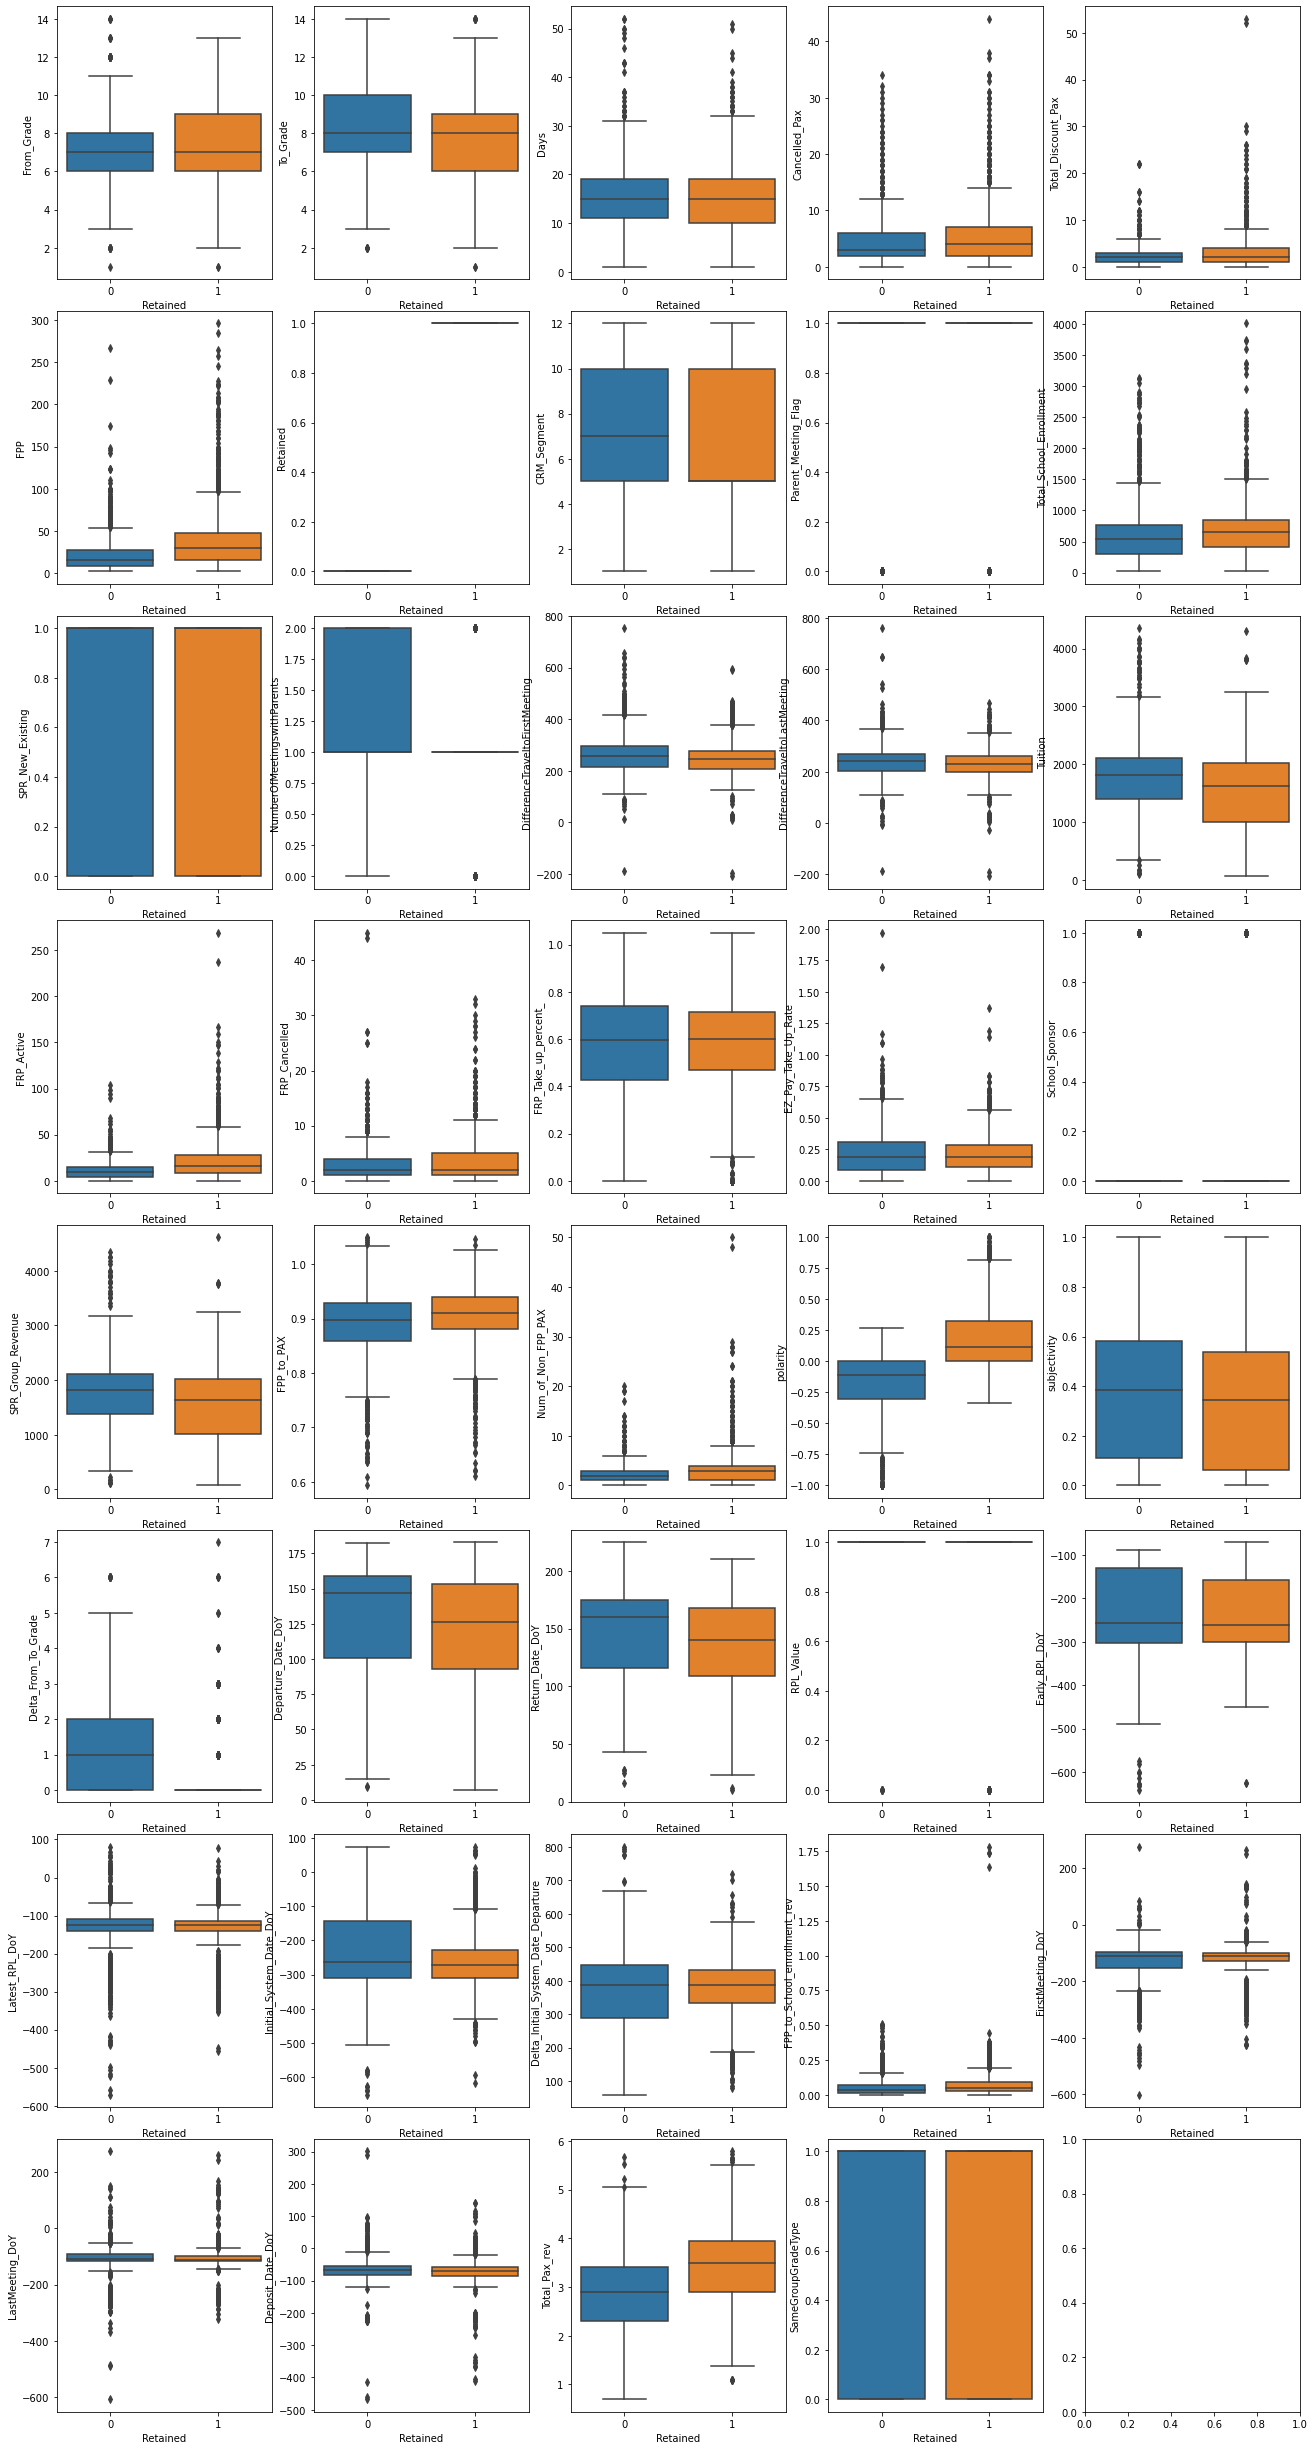

In [18]:
%matplotlib inline

fig, axes = plt.subplots(ncols=5, nrows=8, figsize=(18,34))
fig.tight_layout()

for i, feature in enumerate(Numerical):
    sns.boxplot(y = feature, x = "Retained",data=df, orient='v', ax=axes[int(i/5),i%5])

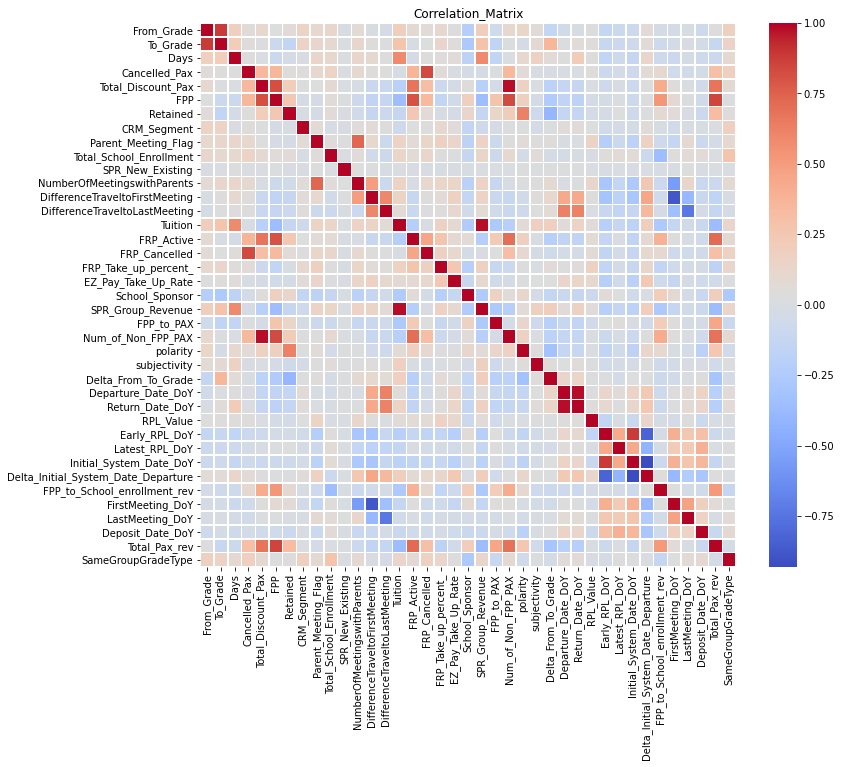

In [19]:
data_to_heatmap = df[Numerical]

plt.figure(figsize = (12,10))
sns.heatmap(data=data_to_heatmap.corr().round(2), cmap='coolwarm', linewidths=.5, annot=False, annot_kws={"size":10}).set_title('Correlation_Matrix')
plt.show()

<AxesSubplot:>

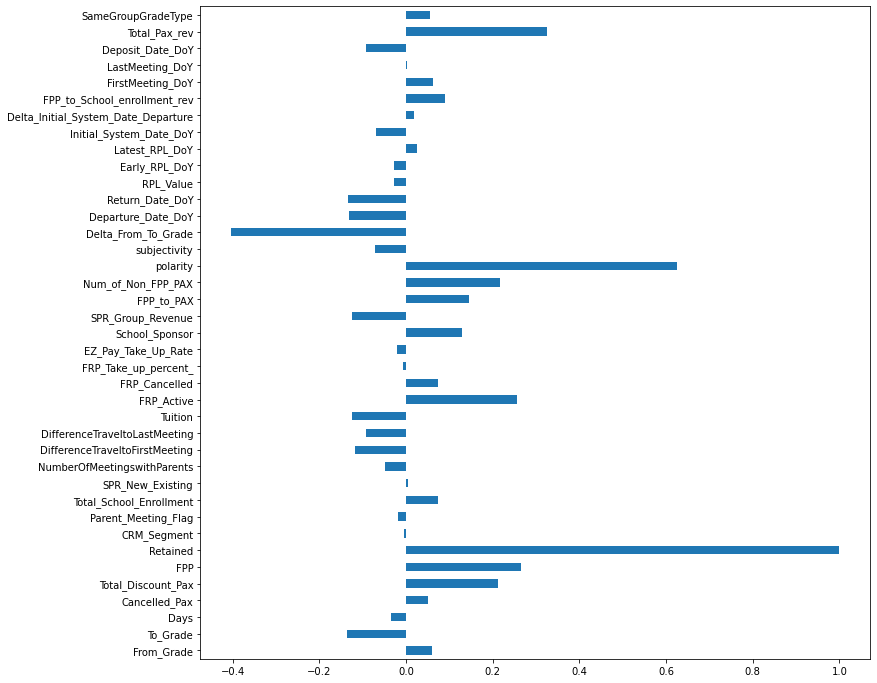

In [20]:
plt.figure(figsize = (12,12))
data_to_heatmap[data_to_heatmap.columns[:]].corr()['Retained'][:].plot(kind='barh')

<AxesSubplot:xlabel='polarity', ylabel='Count'>

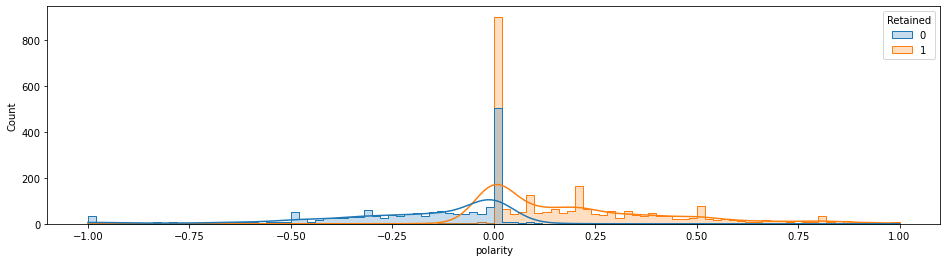

In [21]:
plt.figure(figsize=(16,4))
sns.histplot(data=df, x='polarity', hue="Retained", element="step", kde=True, bins=100)

**Polarity seems really important!**

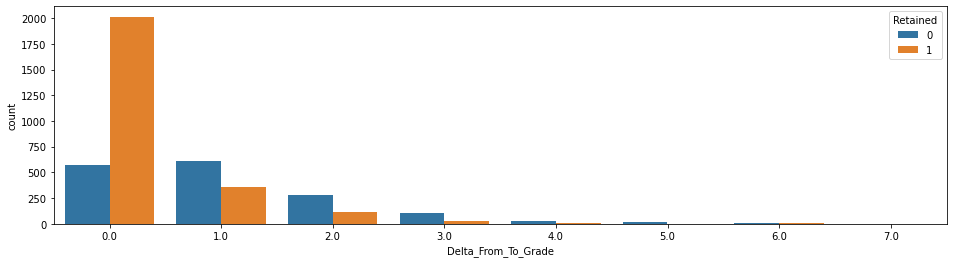

In [22]:
plt.figure(figsize=(16,4))
sns.countplot(x='Delta_From_To_Grade', hue='Retained', data=df)
plt.legend(loc='upper right', title='Retained')

**... and also the distance from lowest to highest grade in school of participants. When zero it represents an indicator for the trip taken by a group comprising students from the same grade.**

In [23]:
df = dummification(df)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4148 entries, 0 to 4147
Columns: 242 entries, From_Grade to Special_Pay_SA
dtypes: float64(12), int32(7), int64(20), uint8(203)
memory usage: 2.1 MB


#### Feature Selection

In [25]:
#Low variance variables
selector = feature_selection.VarianceThreshold(threshold=0.02)
selector.fit_transform(df[Numerical])

print('Low variance variables (to be removed):')
print(df[Numerical].columns[selector.get_support()==False].tolist())

Low variance variables (to be removed):
['FPP_to_PAX', 'RPL_Value', 'FPP_to_School_enrollment_rev']


In [26]:
mm_scaler =  MinMaxScaler(copy=False,feature_range=(0, 1))
df_scaled = mm_scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=list(df))


X=df_scaled.drop(columns=['Retained'])

y=df_scaled['Retained']

selector_chi=SelectKBest(feature_selection.chi2, k=5)
selector_f=SelectKBest(feature_selection.f_classif, k=5)

#Test
#classification: chi2, f_classif, mutual_info_classif
#regression: f_regression, mutual_info_regression

X_chi = pd.DataFrame(selector_chi.fit_transform(X, y),columns=X.columns[selector_chi.get_support()])
X_f = pd.DataFrame(selector_f.fit_transform(X, y),columns=X.columns[selector_f.get_support()])

In [27]:
print('Chi2 and ANOVA F value selected features:')
print(X.columns[selector_chi.get_support()].tolist())
print(X.columns[selector_f.get_support()].tolist())

Chi2 and ANOVA F value selected features:
['Delta_From_To_Grade', 'GroupGradeType_High->High', 'SchoolGradeTypeLow_High', 'SchoolGradeTypeHigh_High', 'SchoolGradeType_High->High']
['FPP', 'FRP_Active', 'polarity', 'Delta_From_To_Grade', 'Total_Pax_rev']


In [28]:
embeded_lr_selector = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'), max_features=5)
embeded_lr_selector.fit(X, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print('LASSO selected features:')
print(embeded_lr_feature)

LASSO selected features:
['polarity', 'Delta_From_To_Grade', 'Total_Pax_rev', 'Program_Code_HC', 'MajorProgramCode_C']


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4148 entries, 0 to 4147
Columns: 242 entries, From_Grade to Special_Pay_SA
dtypes: float64(12), int32(7), int64(20), uint8(203)
memory usage: 2.1 MB


In [30]:
#df.to_excel("final.xlsx")

<a id="Model"></a>
## The Model
Selected features from previous tests and manual try and error

In [31]:
#Retained is the target 
Selected_Features = ['Retained',
                     'polarity',
                     'Delta_From_To_Grade',
                     'Total_Pax_rev',
                     'SPR_Product_Type_East Coast',
                    ]

**The model could be further improved by including other features or by choosing more sophisticated learning methods, however we preferred to choose a simple and easy to read model**

In [32]:
df_subset = df[Selected_Features]

X = df_subset.drop(columns=['Retained'])
y = df_subset['Retained']

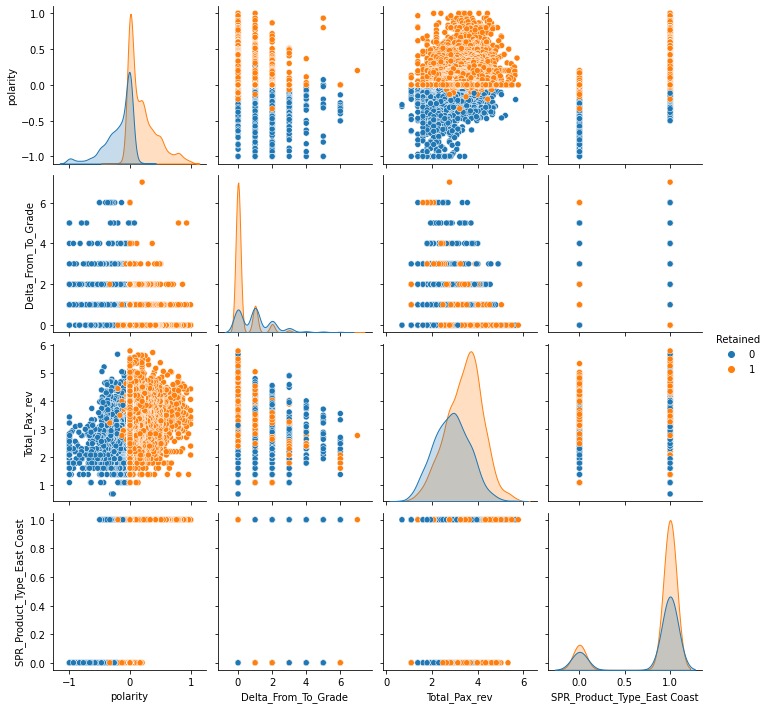

In [33]:
sns.pairplot(df_subset,hue='Retained')

In [34]:
#SPLIT DATA INTO TRAIN AND TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y,  #X_scaled
                                                    test_size =0.30, #by default is 75%-25%
                                                    #shuffle is set True by default,
                                                    stratify=y,
                                                    random_state= 231) #fix random seed for replicability

print(X_train.shape)
print(X_test.shape)

(2903, 4)
(1245, 4)


### Classification Tree

In [35]:
#DEFINE YOUR CLASSIFIER and THE PARAMETERS GRID

classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth': [3,4,5,6,7],
              'min_samples_split': [8,9,10],
              'min_samples_leaf': [8,9,10]}

In [36]:
#DEFINE YOUR GRIDSEARCH 
'''
GS perfoms an exhaustive search over specified parameter values for an estimator.
GS uses a Stratified K-Folds cross-validator
(The folds are made by preserving the percentage of samples for each class.)
If refit=True the model is retrained on the whole training set with the best found params
'''
gs = GridSearchCV(classifier, parameters, cv=5, scoring = 'f1', verbose=10, n_jobs=-1, refit=True)

In [37]:
#TRAIN YOUR CLASSIFIER
gs = gs.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1781s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0846s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0842s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1945s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 288 t

In [38]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.933744 using {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 8}
0.898857 (0.012907) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 8}
0.898857 (0.012907) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 9}
0.898857 (0.012907) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 10}
0.898857 (0.012907) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 9, 'min_samples_split': 8}
0.898857 (0.012907) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 9, 'min_samples_split': 9}
0.898857 (0.012907) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 9, 'min_samples_split': 10}
0.898857 (0.012907) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 8}
0.898857 (0.012907) with: {'criterion': 'entropy', 'max_depth'

In [39]:
best_model = gs.best_estimator_

#TEST ON YOUR TEST & TRAIN SET 
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

#EVALUATE YOUR PREDICTION (on the y_train)
print('***RESULTS ON TRAIN SET***')
print("f1_score: ", metrics.f1_score(y_train, y_pred_train))

print('\n')

#EVALUATE YOUR PREDICTION (on the y_test that you left aside)
print('***RESULTS ON TEST SET***')
print("f1_score: ", metrics.f1_score(y_test, y_pred))

***RESULTS ON TRAIN SET***
f1_score:  0.9361344537815127


***RESULTS ON TEST SET***
f1_score:  0.9207596594629993


In [40]:
#PRINT SOME FURTHER METRICS
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       489
           1       0.91      0.93      0.92       756

    accuracy                           0.90      1245
   macro avg       0.90      0.90      0.90      1245
weighted avg       0.90      0.90      0.90      1245



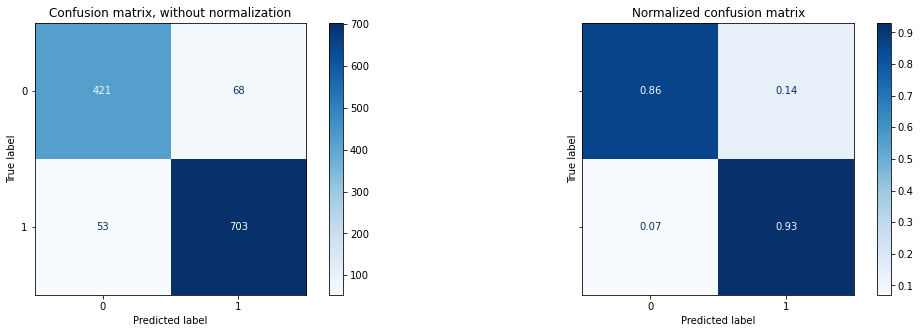

In [41]:
# Plot confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(18, 5), sharey='row')

titles_options = [("Confusion matrix, without normalization", None, 0),
                  ("Normalized confusion matrix", 'true', 1)]
for title, normalize, index in titles_options:
    disp = plot_confusion_matrix(best_model, X_test, y_test,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize,
                                 ax=ax[index])
    disp.ax_.set_title(title)

plt.show()

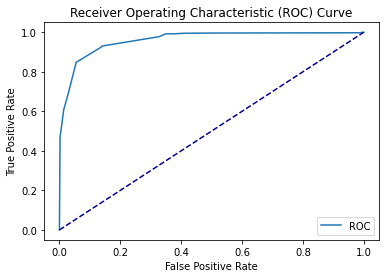

AUC: 0.96


In [42]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

y_probs = best_model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

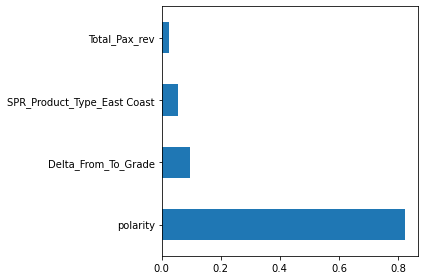

In [43]:
# FEATURE IMPORTANCE:

feat_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values(ascending=False)
x = feat_importances.nlargest(20)
x.plot(kind='barh')
plt.gcf().subplots_adjust(bottom=0.15)
plt.tight_layout()


feat_importances=feat_importances.reset_index()
feat_importances=feat_importances.rename(columns={'index':'features', 0:'importance'})

In [44]:
from sklearn import tree
r = tree.export_text(best_model,feature_names=X_test.columns.tolist())
print(r)

|--- polarity <= -0.00
|   |--- polarity <= -0.11
|   |   |--- Total_Pax_rev <= 4.44
|   |   |   |--- polarity <= -0.13
|   |   |   |   |--- class: 0
|   |   |   |--- polarity >  -0.13
|   |   |   |   |--- class: 0
|   |   |--- Total_Pax_rev >  4.44
|   |   |   |--- class: 0
|   |--- polarity >  -0.11
|   |   |--- Delta_From_To_Grade <= 0.50
|   |   |   |--- Total_Pax_rev <= 2.92
|   |   |   |   |--- class: 0
|   |   |   |--- Total_Pax_rev >  2.92
|   |   |   |   |--- class: 0
|   |   |--- Delta_From_To_Grade >  0.50
|   |   |   |--- Delta_From_To_Grade <= 2.50
|   |   |   |   |--- class: 0
|   |   |   |--- Delta_From_To_Grade >  2.50
|   |   |   |   |--- class: 0
|--- polarity >  -0.00
|   |--- polarity <= 0.00
|   |   |--- Delta_From_To_Grade <= 0.50
|   |   |   |--- Total_Pax_rev <= 3.28
|   |   |   |   |--- class: 1
|   |   |   |--- Total_Pax_rev >  3.28
|   |   |   |   |--- class: 1
|   |   |--- Delta_From_To_Grade >  0.50
|   |   |   |--- SPR_Product_Type_East Coast <= 0.50
|   |

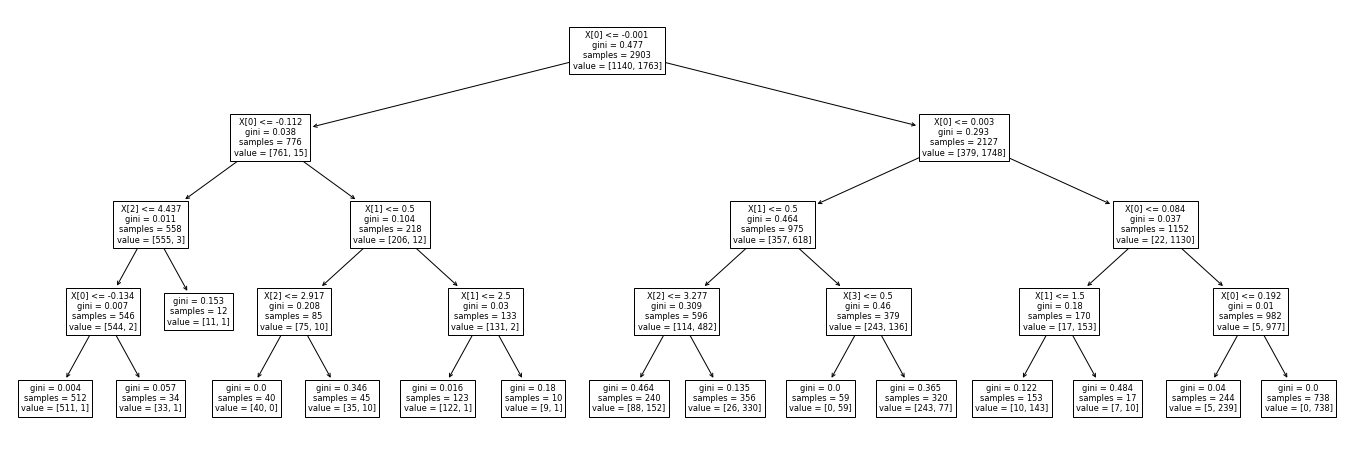

In [45]:
plt.figure(figsize=(24,8))
tree.plot_tree(best_model);

### Random Forest (only for comparison)

In [46]:
#DEFINE YOUR CLASSIFIER and THE PARAMETERS GRID

classifier = RandomForestClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'n_estimators': [30, 40],
              'max_depth': [4,5,6,7],
              'min_samples_split': [4,5,6,7],
              'min_samples_leaf': [4,5,6,7]}

In [47]:
#DEFINE YOUR GRIDSEARCH 
'''
GS perfoms an exhaustive search over specified parameter values for an estimator.
GS uses a Stratified K-Folds cross-validator
(The folds are made by preserving the percentage of samples for each class.)
If refit=True the model is retrained on the whole training set with the best found params
'''
gs = GridSearchCV(classifier, parameters, cv=5, scoring = 'f1', verbose=10, n_jobs=-1, refit=True)

#TRAIN YOUR CLASSIFIER
gs = gs.fit(X_train, y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1328s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 314 tas

In [48]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.936393 using {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 40}
0.935224 (0.008934) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 30}
0.935234 (0.008314) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 40}
0.935313 (0.008335) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 30}
0.935234 (0.008314) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 40}
0.934968 (0.009196) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 30}
0.936057 (0.007479) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 40}
0.935184 (0.008975) with: {'criterio

In [49]:
best_model = gs.best_estimator_

#TEST ON YOUR TEST & TRAIN SET 
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

#EVALUATE YOUR PREDICTION (on the y_train)
print('***RESULTS ON TRAIN SET***')
print("f1_score: ", metrics.f1_score(y_train, y_pred_train))

print('\n')

#EVALUATE YOUR PREDICTION (on the y_test that you left aside)
print('***RESULTS ON TEST SET***')
print("f1_score: ", metrics.f1_score(y_test, y_pred))

***RESULTS ON TRAIN SET***
f1_score:  0.9364323718846261


***RESULTS ON TEST SET***
f1_score:  0.9201570680628273


In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       489
           1       0.91      0.93      0.92       756

    accuracy                           0.90      1245
   macro avg       0.90      0.89      0.90      1245
weighted avg       0.90      0.90      0.90      1245



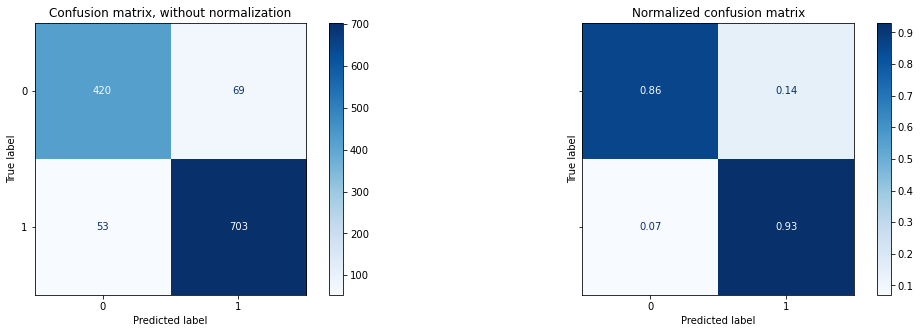

In [51]:
# Plot confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(18, 5), sharey='row')

titles_options = [("Confusion matrix, without normalization", None, 0),
                  ("Normalized confusion matrix", 'true', 1)]
for title, normalize, index in titles_options:
    disp = plot_confusion_matrix(best_model, X_test, y_test,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize,
                                 ax=ax[index])
    disp.ax_.set_title(title)

plt.show()

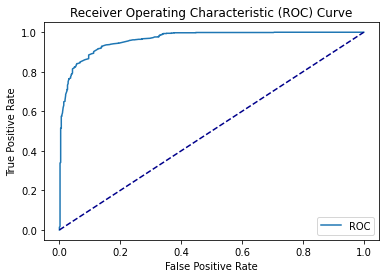

AUC: 0.96


In [52]:
y_pred = best_model.predict(X_test)

y_probs = best_model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

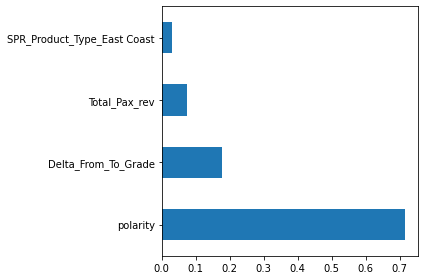

In [53]:
# FEATURE IMPORTANCE:

feat_importances = dict(zip(X_train.columns, best_model))
feat_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values(ascending=False)
x = feat_importances.nlargest(20)
x.plot(kind='barh')
plt.gcf().subplots_adjust(bottom=0.15)
plt.tight_layout()


feat_importances=feat_importances.reset_index()
feat_importances=feat_importances.rename(columns={'index':'features', 0:'importance'})